In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.utils.data as data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import time

from torchsummary import summary

from sklearn.model_selection import train_test_split

from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

######### SET PARAMETERS #########
bs = 4
lr = 0.1
epochs = 50
seed = 0
N=10
split = 0.2

#Reproducability
torch.manual_seed(seed)

In [2]:
#Compute mean and standard deviation of a dataset 

#METHOD 1
def dataset_mean_std(loader):
    mean = 0.0
    std = 0.0
    var = 0.0
    for image, label in loader:
        #image (10,3,56,56)
        #label (10)

        image = image.view(image.size(0), image.size(1), -1) 
        mean = mean + image.mean(2).sum(0)
        var = var + image.var(2).sum(0)

    mean = mean / len(loader.dataset)
    var = var / len(loader.dataset)
    std = torch.sqrt(var)
    
    return mean, std

#METHOD 2 (less accurate)
#data = next(iter(rawloader))
#print(data[0].mean(), data[0].std())


In [3]:
######## LOADS AND SPLITS TRAIN, VALID DATA ########
def load_data(batch_size, split): 

    full = datasets.ImageFolder(root='training_v2/',transform = transforms.ToTensor()) 
    print(full)
    full_loader = data.DataLoader(full,batch_size = len(full), shuffle=True)    
    
    # Calculate mean of full dataset 
    mean, std = dataset_mean_std(full_loader) 
    print(mean,std)

    # Normalize the full dataset
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
    
    # Define train & test datasets (just copies of the normalized full, to be split in the next lines)
    train = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans)
    test = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans) 

    # Split normalized train & test 
    idxs = list(range(len(train))) #create indices from 0 to the number of training data
    split = int(np.floor(split * len(train))) #rounded up to closest integers
    
    np.random.shuffle(idxs) #shuffle the numbers of the indices (so train and test are split randomly)

    train_idx, test_idx = idxs[split:], idxs[:split]

    train_samp = SubsetRandomSampler(train_idx) #randomly assigning samples to train/test
    test_samp = SubsetRandomSampler(test_idx)

    trainloader = data.DataLoader(train, sampler = train_samp, batch_size=batch_size)
    testloader = data.DataLoader(test, sampler = test_samp)
    
    return trainloader, testloader #randomly split data 


In [4]:
######## DEFINE CNN CLASS ########
class CNN(nn.Module): ####################################################################################
    def __init__(self):
        super(CNN, self).__init__()
        #NUMBER OF KERNELS (Pick 10,30)
        self.conv1 = nn.Conv2d(3, 30, 3) #(rgb channels, kernels, size of kernels 3x3) <-- stride = 1 by default
        self.pool = nn.MaxPool2d(2, 2) #(size 2x2, stride 2)
        self.conv1_BN = nn.BatchNorm2d(30)
        
        self.conv2 = nn.Conv2d(30, 30, 3) #(input channels = output feature map from first layer) 
        self.conv2_BN = nn.BatchNorm2d(30)
        
        self.conv3 = nn.Conv2d(30, 30, 3)
        self.conv3_BN = nn.BatchNorm2d(30)
        
        self.conv4 = nn.Conv2d(30, 30, 3)
        self.conv4_BN = nn.BatchNorm2d(30)

        
        #NUMBER OF NEURONS (Pick 8,32)
        self.fc1 = nn.Linear(30,50) #(8x5x5 = 200 inputs for each neuron, 100 neurons) #INPUT= SIZE OF LAST POOL (-,1,2,3)
        self.fc2 = nn.Linear(50, 10) #(100 input neurons, 10 outputs/classes)
        
        self.fc1_BN = nn.BatchNorm1d(50)

    def forward(self, x): #x is input 
        x = F.relu(self.conv1_BN(self.conv1(x))) 
        #print("1",x.shape)
        x = self.pool(x) 
        #print("2",x.shape)

        x = F.relu(self.conv2_BN(self.conv2(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
     
        x = F.relu(self.conv3_BN(self.conv3(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)
        
        x = F.relu(self.conv4_BN(self.conv4(x))) 
        #print("3",x.shape)
        x = self.pool(x) 
        #print("4",x.shape)

        x = x.view(-1, 30) #OUTPUT= SIZE OF LAST POOL (-,1 2 3) #########
        #print("5",x.shape)

        x = self.fc1_BN(self.fc1(x)) 
        #print("6",x.shape)
        x = self.fc2(x) #(10,10)
        #print("7",x.shape)

        return x

In [5]:
######## INSTANTIATE MODEL, DEFINE LOSS FCN & OPTIMIZER ########
def load_model(learning_rate):
    
    model = CNN() 
    loss_fnc = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 

    return model, loss_fnc, optimizer

In [6]:
######## CALCULATES BATCHACC (in training) ########
def accuracy(predictions, labels):
    correct = 0 
    total = 0
    
    _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
    total = total + len(labels) 
    correct = correct + (predicted.float() == labels).sum() 


    batchacc = correct.item() / total
    return batchacc
    

In [7]:
######## CALCULATES VALIDATION ACC & LOSS (at end of each epoch) ########
def evaluate(model, val_loader):
    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    labelsaccum = []
    predictedaccum = []
    
    for i,data in enumerate(val_loader,0): #go through each batch in val_loader
        inputs, labels = data
        predictions = model(inputs.float())    
        
        # Calculate accuracy 
        _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
        
        total = total + len(labels) 
        
        correct = correct + (predicted.float() == labels.float()).sum() 
        acc = correct.item() / total
        
        # Calculate loss
        loss = loss_fnc(predictions, labels.long())
        batchloss_accum = batchloss_accum + batchloss.item()
        labelsaccum = labelsaccum + [labels.item()]
        predictedaccum = predictedaccum + [predicted.item()]
        
    # Plot a confusion matrix for validation data each epoch 
    matrix = confusion_matrix(labelsaccum,predictedaccum) #compute the matrix first 
    classes = ['A', 'B', 'C', 'D','E', 'F', 'G', 'H', 'I', 'K']
    
    cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [c for c in classes])
    sn.heatmap(cm, annot=True)
    plt.show()
    
    avgbatchloss = batchloss_accum/len(train_loader)
    
    return acc, avgbatchloss
        


Dataset ImageFolder
    Number of datapoints: 3815
    Root location: training_v2/
    StandardTransform
Transform: ToTensor()
tensor([0.6876, 0.6190, 0.5674]) tensor([0.1352, 0.1674, 0.1785])


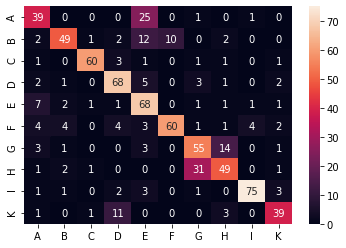

avg acc/epoch 0.467562254259502
[1,   763] avg loss/epoch: 1.581
validation loss: 1.0278234481811523
validation acc: 0.7365661861074705


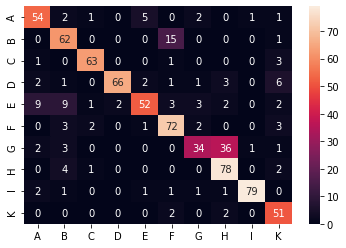

avg acc/epoch 0.6808650065530799
[2,   763] avg loss/epoch: 0.991
validation loss: 0.6377351880073547
validation acc: 0.8007863695937091


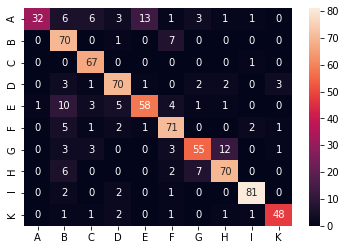

avg acc/epoch 0.7250982961992136
[3,   763] avg loss/epoch: 0.887
validation loss: 1.0973612070083618
validation acc: 0.8152031454783748


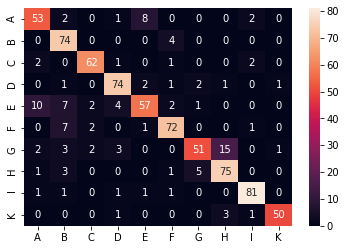

avg acc/epoch 0.7709698558322412
[4,   763] avg loss/epoch: 0.751
validation loss: 0.15814736485481262
validation acc: 0.8505897771952818


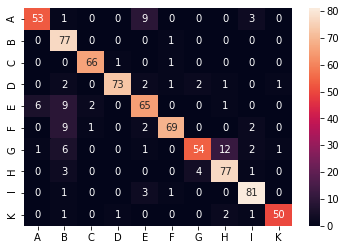

avg acc/epoch 0.7919397116644823
[5,   763] avg loss/epoch: 0.679
validation loss: 0.22022253274917603
validation acc: 0.8715596330275229


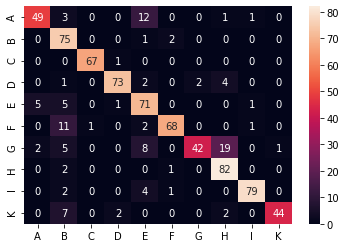

avg acc/epoch 0.8112712975098296
[6,   763] avg loss/epoch: 0.620
validation loss: 0.48372864723205566
validation acc: 0.8519003931847968


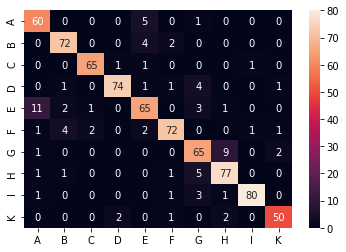

avg acc/epoch 0.8207732634338138
[7,   763] avg loss/epoch: 0.584
validation loss: 0.149847611784935
validation acc: 0.891218872870249


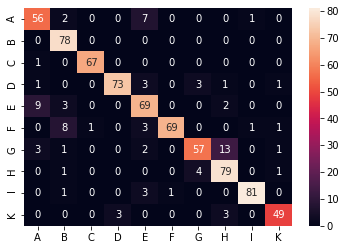

avg acc/epoch 0.833224115334207
[8,   763] avg loss/epoch: 0.549
validation loss: 0.18630781769752502
validation acc: 0.8885976408912188


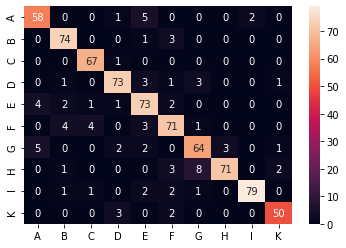

avg acc/epoch 0.8358453473132372
[9,   763] avg loss/epoch: 0.531
validation loss: 0.5897408723831177
validation acc: 0.891218872870249


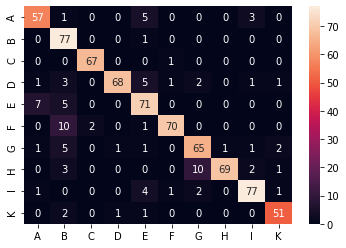

avg acc/epoch 0.8541939711664482
[10,   763] avg loss/epoch: 0.482
validation loss: 0.366205632686615
validation acc: 0.8807339449541285


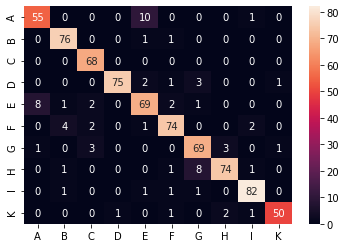

avg acc/epoch 0.8636959370904325
[11,   763] avg loss/epoch: 0.470
validation loss: 0.29425039887428284
validation acc: 0.9069462647444299


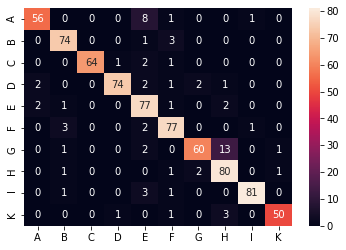

avg acc/epoch 0.8646788990825688
[12,   763] avg loss/epoch: 0.444
validation loss: 0.25513261556625366
validation acc: 0.908256880733945


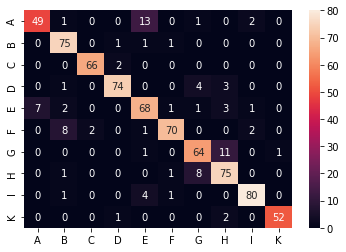

avg acc/epoch 0.8669724770642202
[13,   763] avg loss/epoch: 0.432
validation loss: 0.1749710589647293
validation acc: 0.8820445609436435


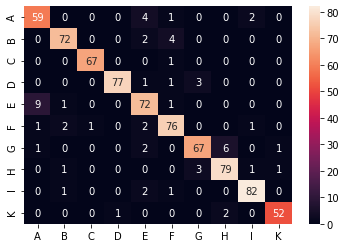

avg acc/epoch 0.8676277850589778
[14,   763] avg loss/epoch: 0.445
validation loss: 0.182358518242836
validation acc: 0.9213630406290957


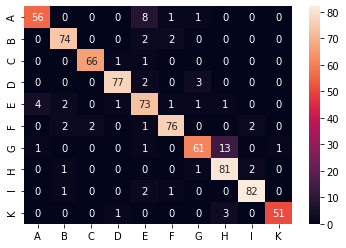

avg acc/epoch 0.8781127129750983
[15,   763] avg loss/epoch: 0.395
validation loss: 0.02978026680648327
validation acc: 0.9134993446920052


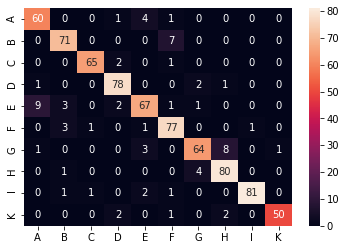

avg acc/epoch 0.8813892529488859
[16,   763] avg loss/epoch: 0.394
validation loss: 0.03304707258939743
validation acc: 0.908256880733945


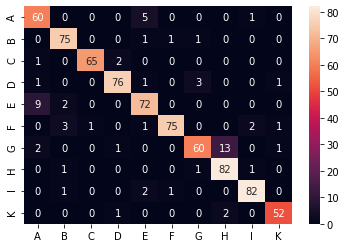

avg acc/epoch 0.882699868938401
[17,   763] avg loss/epoch: 0.383
validation loss: 0.3898855447769165
validation acc: 0.9161205766710354


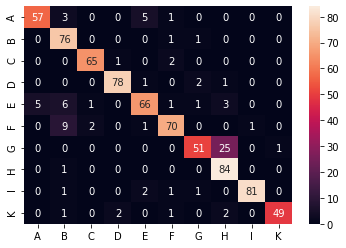

avg acc/epoch 0.8823722149410222
[18,   763] avg loss/epoch: 0.386
validation loss: 0.4104180932044983
validation acc: 0.8872870249017037


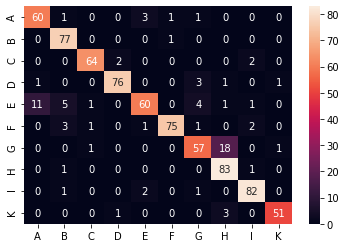

avg acc/epoch 0.8889252948885976
[19,   763] avg loss/epoch: 0.353
validation loss: 0.0074093700386583805
validation acc: 0.8977719528178244


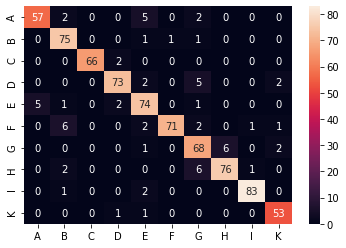

avg acc/epoch 0.891218872870249
[20,   763] avg loss/epoch: 0.368
validation loss: 0.2451014518737793
validation acc: 0.9121887287024901


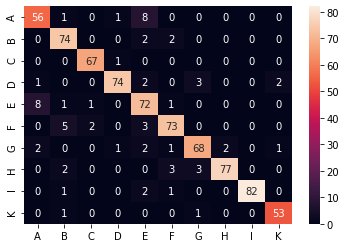

avg acc/epoch 0.88564875491481
[21,   763] avg loss/epoch: 0.357
validation loss: 0.19360780715942383
validation acc: 0.9121887287024901


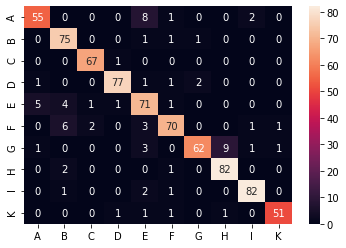

avg acc/epoch 0.8958060288335518
[22,   763] avg loss/epoch: 0.336
validation loss: 0.00131544703617692
validation acc: 0.9069462647444299


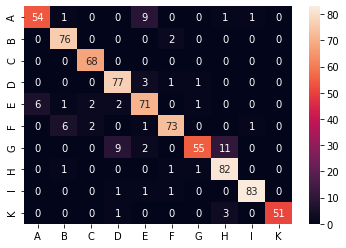

avg acc/epoch 0.9089121887287025
[23,   763] avg loss/epoch: 0.296
validation loss: 1.7303775548934937
validation acc: 0.9043250327653998


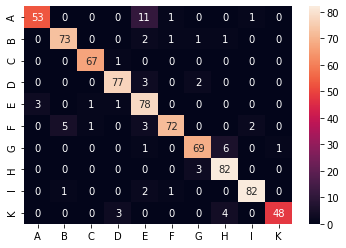

avg acc/epoch 0.8961336828309305
[24,   763] avg loss/epoch: 0.320
validation loss: 0.01540989987552166
validation acc: 0.9187418086500655


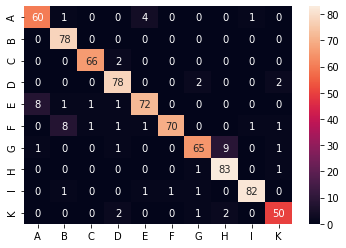

avg acc/epoch 0.898427260812582
[25,   763] avg loss/epoch: 0.310
validation loss: 0.005693497136235237
validation acc: 0.9226736566186108


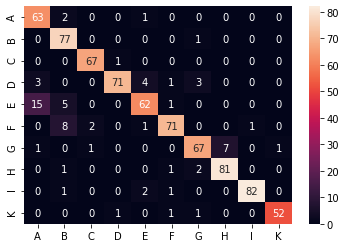

avg acc/epoch 0.8908912188728703
[26,   763] avg loss/epoch: 0.359
validation loss: 0.09597329795360565
validation acc: 0.908256880733945


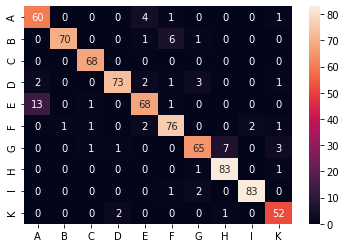

avg acc/epoch 0.901048492791612
[27,   763] avg loss/epoch: 0.320
validation loss: 0.12716394662857056
validation acc: 0.9148099606815203


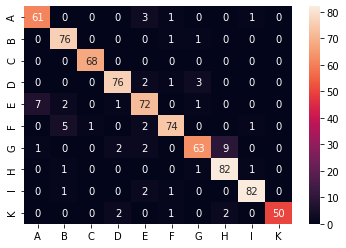

avg acc/epoch 0.90956749672346
[28,   763] avg loss/epoch: 0.293
validation loss: 0.4590894877910614
validation acc: 0.9226736566186108


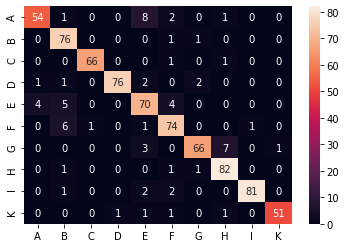

avg acc/epoch 0.9134993446920052
[29,   763] avg loss/epoch: 0.286
validation loss: 0.2564511299133301
validation acc: 0.9121887287024901


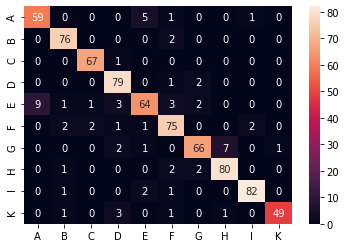

avg acc/epoch 0.9105504587155964
[30,   763] avg loss/epoch: 0.296
validation loss: 0.08713600039482117
validation acc: 0.9134993446920052


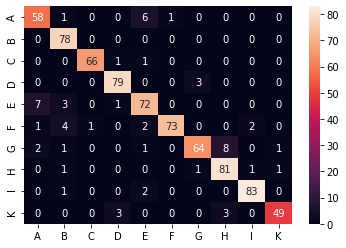

avg acc/epoch 0.9171035386631717
[31,   763] avg loss/epoch: 0.264
validation loss: 0.33352038264274597
validation acc: 0.9213630406290957


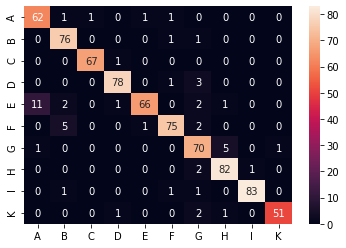

avg acc/epoch 0.9144823066841415
[32,   763] avg loss/epoch: 0.268
validation loss: 0.5011672973632812
validation acc: 0.9305373525557011


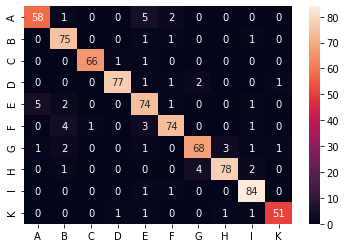

avg acc/epoch 0.9243119266055045
[33,   763] avg loss/epoch: 0.245
validation loss: 0.010170252062380314
validation acc: 0.9239842726081258


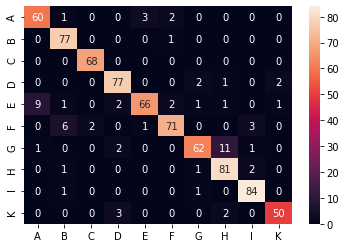

avg acc/epoch 0.9203800786369594
[34,   763] avg loss/epoch: 0.249
validation loss: 0.6727132201194763
validation acc: 0.9121887287024901


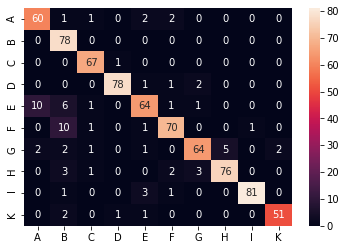

avg acc/epoch 0.9216906946264745
[35,   763] avg loss/epoch: 0.249
validation loss: 0.27483636140823364
validation acc: 0.9030144167758847


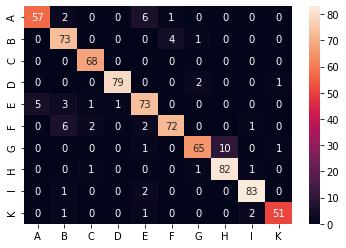

avg acc/epoch 0.9207077326343381
[36,   763] avg loss/epoch: 0.277
validation loss: 0.06284023821353912
validation acc: 0.9213630406290957


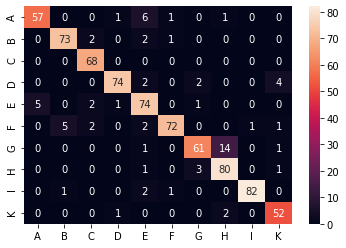

avg acc/epoch 0.9131716906946264
[37,   763] avg loss/epoch: 0.283
validation loss: 0.004876952152699232
validation acc: 0.908256880733945


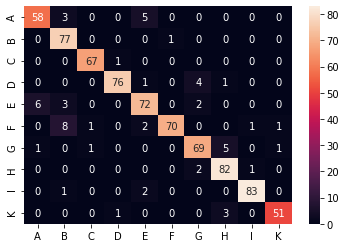

avg acc/epoch 0.9184141546526867
[38,   763] avg loss/epoch: 0.265
validation loss: 0.18890491127967834
validation acc: 0.9239842726081258


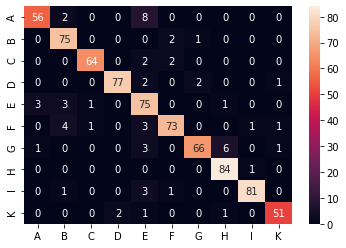

avg acc/epoch 0.9341415465268676
[39,   763] avg loss/epoch: 0.219
validation loss: 1.4083997011184692
validation acc: 0.9200524246395806


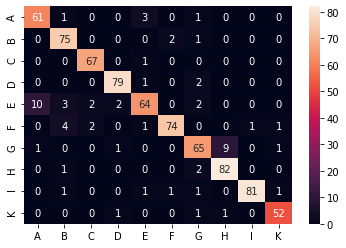

avg acc/epoch 0.9288990825688074
[40,   763] avg loss/epoch: 0.238
validation loss: 0.02739120088517666
validation acc: 0.9174311926605505


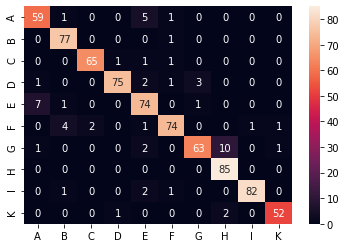

avg acc/epoch 0.9288990825688074
[41,   763] avg loss/epoch: 0.231
validation loss: 0.0042650350369513035
validation acc: 0.9252948885976409


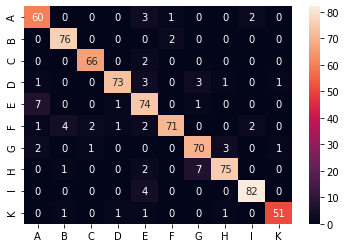

avg acc/epoch 0.9292267365661862
[42,   763] avg loss/epoch: 0.220
validation loss: 0.0033703625667840242
validation acc: 0.9148099606815203


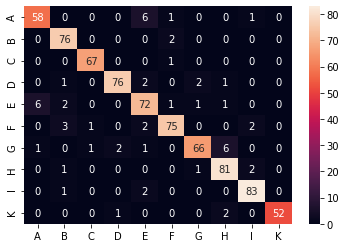

avg acc/epoch 0.9318479685452162
[43,   763] avg loss/epoch: 0.243
validation loss: 0.025075027719140053
validation acc: 0.9252948885976409


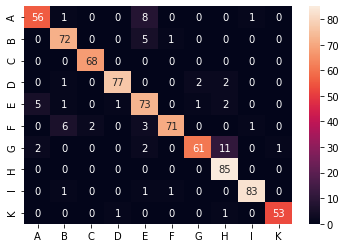

avg acc/epoch 0.9354521625163827
[44,   763] avg loss/epoch: 0.208
validation loss: 0.023608066141605377
validation acc: 0.9161205766710354


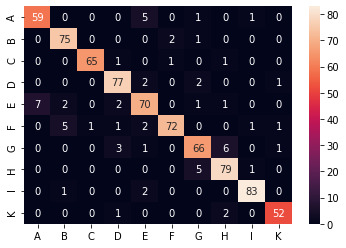

avg acc/epoch 0.9292267365661862
[45,   763] avg loss/epoch: 0.222
validation loss: 0.03742651641368866
validation acc: 0.9148099606815203


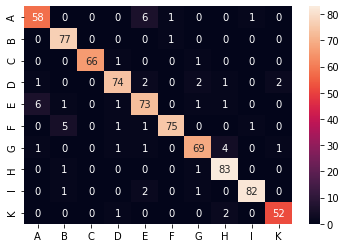

avg acc/epoch 0.9233289646133683
[46,   763] avg loss/epoch: 0.240
validation loss: 0.014165230095386505
validation acc: 0.9292267365661862


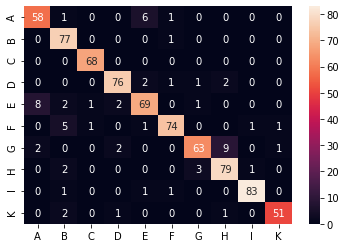

avg acc/epoch 0.9295543905635649
[47,   763] avg loss/epoch: 0.213
validation loss: 0.004645372275263071
validation acc: 0.9148099606815203


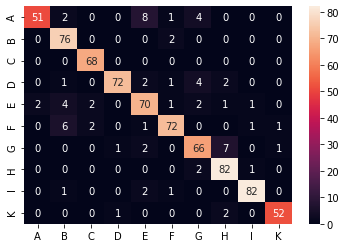

avg acc/epoch 0.9347968545216252
[48,   763] avg loss/epoch: 0.225
validation loss: 0.03840463608503342
validation acc: 0.9056356487549148


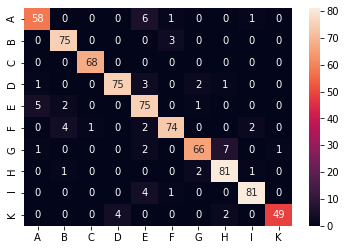

avg acc/epoch 0.935124508519004
[49,   763] avg loss/epoch: 0.212
validation loss: 0.0029920069500803947
validation acc: 0.9200524246395806


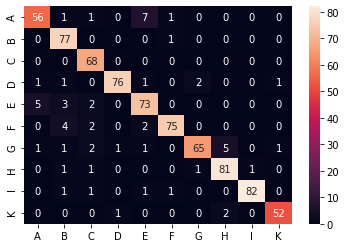

avg acc/epoch 0.9429882044560943
[50,   763] avg loss/epoch: 0.187
validation loss: 0.0009219124913215637
validation acc: 0.9239842726081258
Finished Training
Execution time 1326.976461648941


In [8]:
torch.manual_seed(seed)

# LOAD DATA 
train_loader,val_loader = load_data(bs,split) 
model,loss_fnc,optimizer = load_model(lr) #learning rate (lr) defined here 

# STORE FOR PLOTTING
loss_list = []
acc_list = []
nepoch = []

testacc_list = []
testloss_list = []

# TRAINING LOOP 
start_time = time.time()
for e in range(epochs): 
    nepoch = nepoch + [e]

    batchloss_accum = 0.0
    batchacc_accum = 0.0

    for i, data in enumerate(train_loader, 0): #len trainloader is number of batches 
        model.train() 
        correct = 0 
        total = 0 
        
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #inputs = (10,3,56,56); labels = (10)

        inputs = Variable(inputs).float()
        labels = Variable(labels).float()

        # Zero parameter gradients
        optimizer.zero_grad()

        # Run model on inputs
        #outputs = torch.sigmoid(CNNmodel(inputs)) #(10,10)
        outputs = model(inputs) #(10,10)

        # Compute loss
        batchloss = loss_fnc(outputs, labels.long())
        batchloss.backward()
        optimizer.step()

        batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
        #print('batchloss',batchloss)

        batchacc = accuracy(outputs,labels)
        batchacc_accum = batchacc_accum + batchacc
        #print("Batch accuracy",batchacc)

        if i == len(train_loader)-1: #len(trainloader) is len(dataset) / images per batch
            model.eval() 
            vacc, vloss = evaluate(model,val_loader)
            
            print("avg acc/epoch", batchacc_accum/len(train_loader))
            print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_loader)))
            print("validation loss:", vloss)
            print("validation acc:", vacc)
            
            loss_list = loss_list + [batchloss_accum/len(train_loader)]
            acc_list = acc_list + [batchacc_accum/len(train_loader)]
            testacc_list.append(vacc)   
            testloss_list.append(vloss)

            batchloss_accum = 0.0
            batchacc_accum = 0.0 
            
            # Calculate times at different intervals (just for personal visualization, if we reach that epoch)
            '''if e+1 == 50:
                epoch50_time = time.time() - start_time
            if e+1 == 100:
                epoch100_time = time.time() - start_time
            if e+1 == 200:
                epoch200_time = time.time() - start_time
            if e+1 == 300:
                epoch300_time = time.time() - start_time
            if e+1 == 400:
                epoch400_time = time.time() - start_time'''

endtime = time.time() - start_time
print('Finished Training')
print("Execution time", endtime)

'''print(epoch100_time)
print(epoch200_time)
print(epoch300_time)
print(epoch400_time)'''


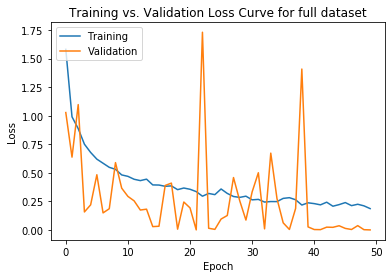

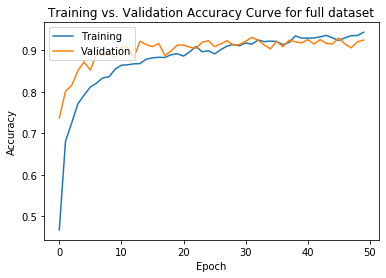

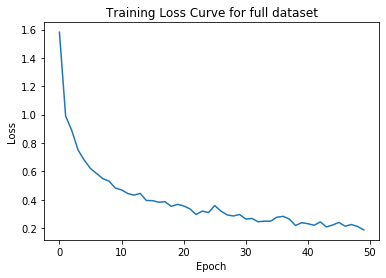

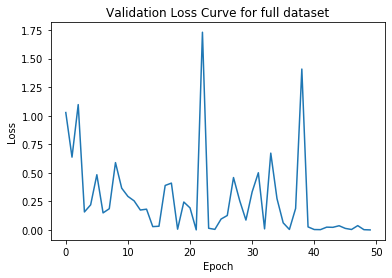

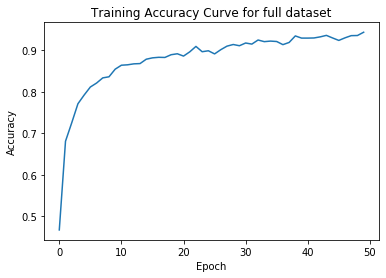

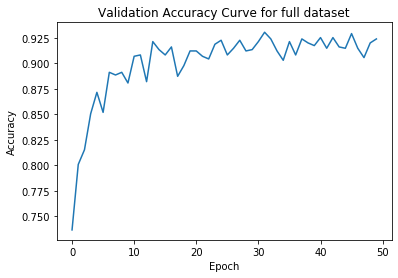

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
       BatchNorm2d-2           [-1, 30, 54, 54]              60
         MaxPool2d-3           [-1, 30, 27, 27]               0
            Conv2d-4           [-1, 30, 25, 25]           8,130
       BatchNorm2d-5           [-1, 30, 25, 25]              60
         MaxPool2d-6           [-1, 30, 12, 12]               0
            Conv2d-7           [-1, 30, 10, 10]           8,130
       BatchNorm2d-8           [-1, 30, 10, 10]              60
         MaxPool2d-9             [-1, 30, 5, 5]               0
           Conv2d-10             [-1, 30, 3, 3]           8,130
      BatchNorm2d-11             [-1, 30, 3, 3]              60
        MaxPool2d-12             [-1, 30, 1, 1]               0
           Linear-13                   [-1, 50]           1,550
      BatchNorm1d-14                   

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CNN(
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_BN): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv2_BN): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv3_BN): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv4_BN): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=30, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc1_BN): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
#LOSS TOGETHER
plt.plot(nepoch,loss_list, label = 'Train')
plt.plot(nepoch,testloss_list, label = 'Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training vs. Validation Loss Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#ACCURACIES TOGETHER
plt.plot(nepoch,acc_list, label = 'Train')
plt.plot(nepoch,testacc_list, label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training vs. Validation Accuracy Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#TRAIN LOSS 
plt.plot(nepoch,loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training Loss Curve for full dataset")
plt.show() 

#VALID LOSS
plt.plot(nepoch,testloss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Validation Loss Curve for full dataset")
plt.show() 

#TRAIN ACC
plt.plot(nepoch,acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training Accuracy Curve for full dataset")
plt.show() 


#VALID ACC
plt.plot(nepoch,testacc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Validation Accuracy Curve for full dataset")
plt.show() 


summary(model, input_size=(3, 56, 56))

# Saving the model
torch.save(model.state_dict(),'MyBest/MyBest.pt') 

Model = CNN()

Model.load_state_dict(torch.load('MyBest/MyBest.pt'))

torch.save(Model,'MyBest/fullbestmodel.pt2')  
model.eval()